In [1]:
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import corner
import copy
import pickle
from astropy.io import ascii
from itertools import cycle
import math
from itertools import permutations

import matplotlib.gridspec as gridspec

%matplotlib inline

# Plotting code

In [2]:
plt.style.use('ggplot')
%config InlineBackend.figure_format = 'retina'
mpl.rcParams['lines.linewidth'] = 2.5
mpl.rcParams['axes.facecolor']='white'
mpl.rcParams['axes.edgecolor']='k'
mpl.rcParams['axes.linewidth']=3
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['text.color'] = 'k'
#mpl.rcParams['xtick.major.width'] = 2
#mpl.rcParams['ytick.major.width'] = 2
mpl.rcParams['xtick.color']='k'
mpl.rcParams['ytick.color']='k'
mpl.rcParams['axes.labelcolor']='k'

mpl.rcParams['font.size']=12
mpl.rcParams['xtick.direction']='in'
mpl.rcParams['ytick.direction']='in'
mpl.rcParams['xtick.major.size'] = 5.5
mpl.rcParams['ytick.major.size'] = 5.5
mpl.rcParams['xtick.minor.size'] = 3.5
mpl.rcParams['ytick.minor.size'] = 3.5


def makeCmap(hexColour,zeroColour='#FFFFFF'):
    r0,g0,b0=mpl.colors.hex2color(zeroColour)
    r,g,b=mpl.colors.hex2color(hexColour)
    cdict = {'red':   ((0.0, r0, r0),
                   (1.0, r, r)),
         'green': ((0.0, g0, g0),
                   (1.0, g, g)),
         'blue':  ((0.0, b0, b0),
                   (1.0, b, b))
        }
    cmap = mpl.colors.LinearSegmentedColormap(hexColour,cdict)
    return cmap


def makeGradient(hexColour):
    r,g,b=mpl.colors.hex2color(hexColour)
    cdict = {'red':   ((0.0, r, r),
                   (1.0, r, r)),
         'green': ((0.0, g, g),
                   (1.0, g, g)),
         'blue':  ((0.0, b, b),
                   (1.0, b, b)),
         'alpha':  ((0.0, 0.0, 0.0),
                   (1.0, 1.0, 1.0))
        }
    cmap = mpl.colors.LinearSegmentedColormap(hexColour,cdict)
    return cmap


def makePlotColours(mappableList,coloursList):
    """
    mappableArray = a list of discrete values, each corresponding to a unique color (zero-indexed)
    coloursList = list of desired colors. Ideally should be at least as many colours as there are unique
                  entries in mappableArray.
    """

    nColours = np.max(mappableList)+1
    uniqueMappableList = np.arange(nColours)
    
    zidx = np.array((mappableList))

    cidx = 0
    colourMaps = []
    cycledColours = []
    for c in cycle(coloursList):
        colourMaps.append(makeGradient(c))
        cycledColours.append(c)
        cidx+=1
        if cidx >= nColours: 
            break
    
    blankCmap=makeGradient('#FFFFFF')
    colours = blankCmap(0.999*np.ones_like(zidx))

    for j in range(0,nColours):
        colours[zidx==j] = colourMaps[j](0.999*np.ones_like(np.arange(0,len(zidx))[zidx==j]))

    return colourMaps,colours,cycledColours,list(uniqueMappableList)

In [3]:
def makePlot(ax, xdata, ydata, colours, xlabel, ylabel, sizes=100,
             legendTitle=None,legendEntries=None, legendColours=None,
             xlim=[], ylim=[],xscale="linear",yscale="linear",alpha=1):
    ax.scatter(xdata,ydata,c=colours,s=sizes,alpha=alpha)
    #ax.hexbin(xdata,ydata,cmap='Blues')
    nonans = (np.isfinite(xdata) & np.isfinite(ydata))
    xdata=xdata[nonans]
    ydata=ydata[nonans]
    colours=colours[nonans]
    
    xmin = np.min(xdata[xdata > 0.])#.value
    xmax = np.max(xdata)#.value
    
    ymin = np.min(ydata[ydata > 0.])#.value
    ymax = np.max(ydata)#.value

    if not xlim:
        if xscale=="log":
            ax.set_xlim(0.1*xmin,10.*xmax)
        else:
            ax.set_xlim(0.95*xmin,1.05*xmax)
    else:
        ax.set_xlim(xlim)
        
    if not ylim:
        if yscale=="log":
            ax.set_ylim(0.1*ymin,10.*ymax)
        else:
            ax.set_ylim(0.95*ymin,1.05*ymax)
    else:
        ax.set_ylim(ylim)
    
    ax.set_xscale(xscale)
    ax.set_yscale(yscale)
    
    ax.set_xlabel(xlabel,fontsize=24)
    ax.set_ylabel(ylabel,fontsize=24)
    ax.tick_params(labelsize=18)
    
    if legendEntries is not None:
        if xscale=="log":
            minx = 1.e-7*xmin
        else:
            minx = -1000+(-1000*xmin)
                
        if yscale=="log":
            miny = 1.e-7*ymin
        else:
            miny = -1000+(-1000*ymin)
            
        for i in range(0,len(legendEntries)):
            ax.scatter([minx,minx],[miny,miny],s=200,c=legendColours[i],edgecolors=legendColours[i],label='{0}'.format(legendEntries[i]))
        leg=ax.legend(loc=0,ncol=1,frameon=False,fontsize=15,title=legendTitle)
        leg.get_title().set_fontsize('22')
    return 

# Planet data in usable format
## each planet object includes some combination of: [Teff, logg, [Fe/H], Rp/R*, P]

In [456]:
experimentClass = "oneGrammar_overlappingRp"
experimentName = "Rp_uniformP_sigma=0.025"
n_planet_features = 2
n_stellar_features = 0
n_features = n_planet_features + n_stellar_features

-1.0653993332048408
1.5370463345810321


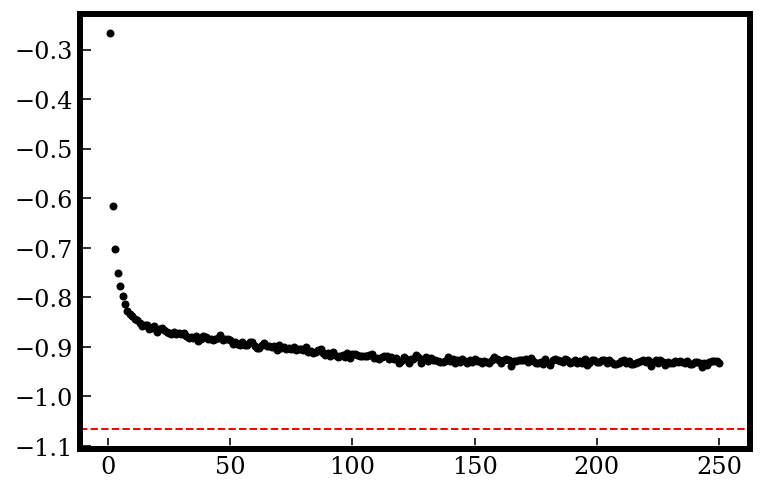

In [457]:
results = np.load("./simulatedPlanets/{0}/fake_grammaticalSystems_{1}_classprobs_softmax.npy".format(experimentClass,experimentName))
results_fromContext = np.load("./simulatedPlanets/{0}/fake_grammaticalSystems_{1}_classprobs_fromcontext_logsoftmax.npy".format(experimentClass,experimentName))

idxs = np.load("./simulatedPlanets/{0}/fake_grammaticalSystems_{1}_idxs.npy".format(experimentClass,experimentName))
losses = np.load("./simulatedPlanets/{0}/fake_grammaticalSystems_{1}_losses.npy".format(experimentClass,experimentName))

optimalLoss = float(np.load("./simulatedPlanets/{0}/fake_grammaticalSystems_{1}_optimalLoss.npy".format(experimentClass,experimentName)))
print(optimalLoss)
bits = -1*optimalLoss*math.log(math.e,2)
print(bits)
plt.plot(losses[:,0],losses[:,1],'k.')
plt.axhline(y=optimalLoss,color='r',ls="--",lw=1)
plt.show()

[[6.10339688e-30 1.31651797e-22 6.10339688e-30 ... 6.32187769e-09
  6.10339688e-30 6.10339688e-30]
 [1.01313879e-42 8.86671603e-41 1.01313879e-42 ... 2.24058949e-09
  1.01313879e-42 1.01313879e-42]
 [1.62521195e-40 1.25010489e-32 1.62521195e-40 ... 2.26022881e-11
  1.62521195e-40 1.62521195e-40]
 ...
 [2.33822857e-12 5.70826014e-05 2.33822857e-12 ... 1.72512028e-02
  2.33822857e-12 2.33822857e-12]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 4.26337243e-10
  0.00000000e+00 0.00000000e+00]
 [1.13121672e-17 3.07249185e-32 3.07249185e-32 ... 3.07249185e-32
  3.07249185e-32 3.07249185e-32]]
[[6.10339688e-30 1.31651797e-22 6.10339688e-30 ... 6.32187769e-09
  6.10339688e-30 6.10339688e-30]
 [1.01313879e-42 8.86671603e-41 1.01313879e-42 ... 2.24058949e-09
  1.01313879e-42 1.01313879e-42]
 [1.62521195e-40 1.25010489e-32 1.62521195e-40 ... 2.26022881e-11
  1.62521195e-40 1.62521195e-40]
 ...
 [2.33822857e-12 5.70826014e-05 2.33822857e-12 ... 1.72512028e-02
  2.33822857e-12 2.33822857e-12]

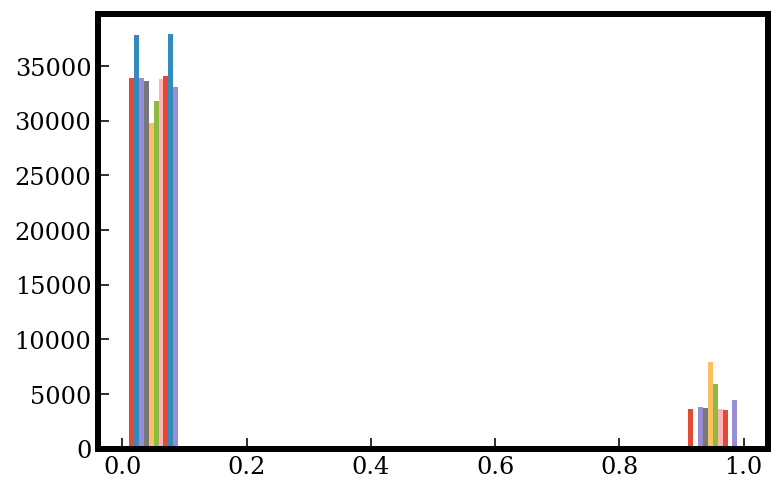

In [458]:
print(results)
print(results)

plt.hist(results)
plt.show()

(37906, 2)
[4 4 4 ... 3 4 6]
(37906,)


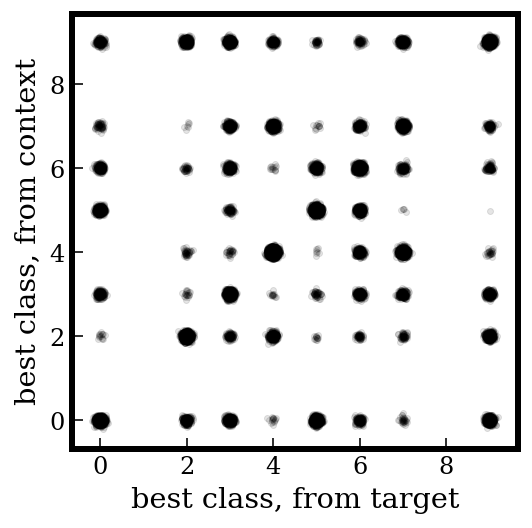

(37906,)
[0 0 0 ... 1 0 1]


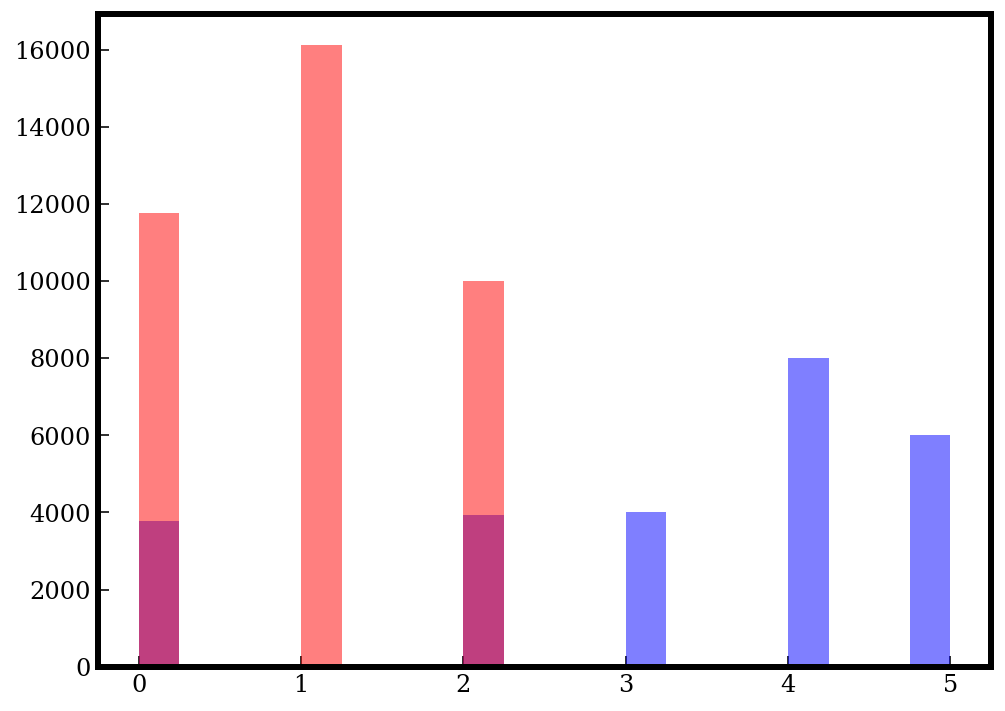

In [459]:
with open("simulatedPlanets/{0}/fake_grammaticalSystems_{1}.txt".format(experimentClass,experimentName), "rb") as picklefile:
    systems = pickle.load(picklefile)

data = np.zeros((1,n_features))

for i in range(len(systems)):
    sys = systems[i]
    for j in range(len(sys)):
        data = np.vstack((data,np.array(sys[j])))
        
data = data[1:][idxs]
print(np.shape(data))

bestClass = np.argmax(results,axis=1)
bestClass_fromContext = np.argmax(results_fromContext,axis=1)
print(bestClass)
print(np.shape(bestClass))

fig = plt.figure(figsize=(4,4))
plt.scatter(bestClass+np.random.normal(loc=0.0,scale=0.05,size=len(bestClass)),
            bestClass_fromContext+np.random.normal(loc=0.0,scale=0.05,size=len(bestClass_fromContext)),
            color='k',marker='.',alpha=0.1)
plt.xlabel("best class, from target")
plt.ylabel("best class, from context")
plt.show()


trueClass = np.load("./simulatedPlanets/{0}/fake_grammaticalSystems_{1}_truths.npy".format(experimentClass,experimentName))
trueClass = trueClass[idxs].astype(int)
print(np.shape(trueClass))
print(trueClass)

#note ---the bars don't line up in this histogram because the class labels are out of order!
fig = plt.figure(figsize=(8,6))
plt.hist(bestClass,bins=20,range=(0,5),color='b',alpha=0.5)
plt.hist(trueClass,bins=20,range=(0,5),color='r',alpha=0.5)
plt.show()

In [460]:
def permuteLabels(trueClass, bestClass, bestClass_fromContext):
    
    #get all possible permutations of 0,1,...,nLabels-1
    nLabels = np.max(bestClass) + 1
    labels = np.arange(nLabels)
    perms = set()
    for perm in permutations(labels):
        perms.add(perm)
    
    perms = list(perms)
    
    bestClass_temp = np.zeros_like(bestClass)
    bestClass_fromContext_temp = np.zeros_like(bestClass_fromContext)
    bestPerm = tuple((0,1,2))
    nTarget_wrong = len(bestClass_temp)
    for p in perms:
        for k in range(0,len(p)):
            bestClass_temp[bestClass == k] = p[k]
            
        #evaluate number of "wrong" labels
        nTarget_wrong_temp = len(np.arange(len(bestClass_temp))[bestClass_temp != trueClass])
        if nTarget_wrong_temp < nTarget_wrong:
            bestPerm = p
            nTarget_wrong = nTarget_wrong_temp
            
    for i in range(nLabels):
        bestClass_temp[bestClass == i] = bestPerm[i]
        bestClass_fromContext_temp[bestClass_fromContext == i] = bestPerm[i]
    
    return bestClass_temp, bestClass_fromContext_temp

In [461]:
bestClass_rearr, bestClass_fromContext_rearr = permuteLabels(trueClass, bestClass, bestClass_fromContext)

KeyboardInterrupt: 

In [462]:
# figure out nWrong, nDisagree, and then see if calculating the loss function on 
#(perfectly confident results with nWrong, wrong)
# matches what we get

print(len(bestClass))

nTarget_wrong = len(np.arange(len(bestClass))[bestClass != trueClass])
nContext_wrong = len(np.arange(len(bestClass))[bestClass_fromContext != trueClass])
nDisagree = len(np.arange(len(bestClass))[bestClass != bestClass_fromContext])

#print(nTarget_wrong)
#print(nContext_wrong)
print(nDisagree)
print(np.unique(bestClass))
print(np.unique(bestClass_fromContext))
#nTarget_wrong = len(np.arange(len(bestClass))[bestClass_rearr != trueClass])
#nContext_wrong = len(np.arange(len(bestClass))[bestClass_fromContext_rearr != trueClass])
#nDisagree = len(np.arange(len(bestClass))[bestClass_rearr != bestClass_fromContext_rearr])

#print(nTarget_wrong)
#print(nContext_wrong)
#print(nDisagree)

37906
16159
[0 2 3 4 5 6 7 9]
[0 2 3 4 5 6 7 9]


In [463]:
print(np.min(data[:,-1]))
print(np.max(data[:,-1]))

-1.7284118802885127
1.741156779292983


In [464]:
#labels = [r'$R_p\ [R_\odot]$']
#scaledLimits = [(-3.5,2.5)]

labels = [r'$R_p\ [R_\odot]$',r'P [days]']
#scaledLimits = [(-1.5,4.),(-1.,4.)]
scaledLimits = [(-1.5,4),(-2.,2.)]

#labels = [r'$R_p\ [R_\odot]$',r'$T_{eff}$ [K]']
#scaledLimits = [(-3.5,2.5),(-4,5.5)]

#labels = [r'$R_p\ [R_\odot]$',r'P [days]',r'$T_{eff}$ [K]',r'$\log{g}\ [\mathrm{cm}/\mathrm{s}^2]',r'[Fe/H]',]
#limits = [(3000,8000),(3.0,5.5),(-1.25,0.6),(0.0,0.3),(0,600)]
#scaledLimits = [(-2,2.5),(-2.,2.),(-4.,5.5),(-4.5,3),(-4,3.5)]


In [465]:
#unscaledData = copy.deepcopy(data)
#unscaledData[:,0] = (unscaledData[:,0]*3.41531066e-02)+5.08794529e-02 #unscale Rp
#unscaledData[:,1] = (unscaledData[:,1]*1.44231050e+02)+2.49761201e+02 #unscale P
#print(np.shape(unscaledData))
#print(np.min(unscaledData[:,0]))
#print(np.max(unscaledData[:,0]))
#print(np.min(unscaledData[:,1]))
#print(np.max(unscaledData[:,1]))

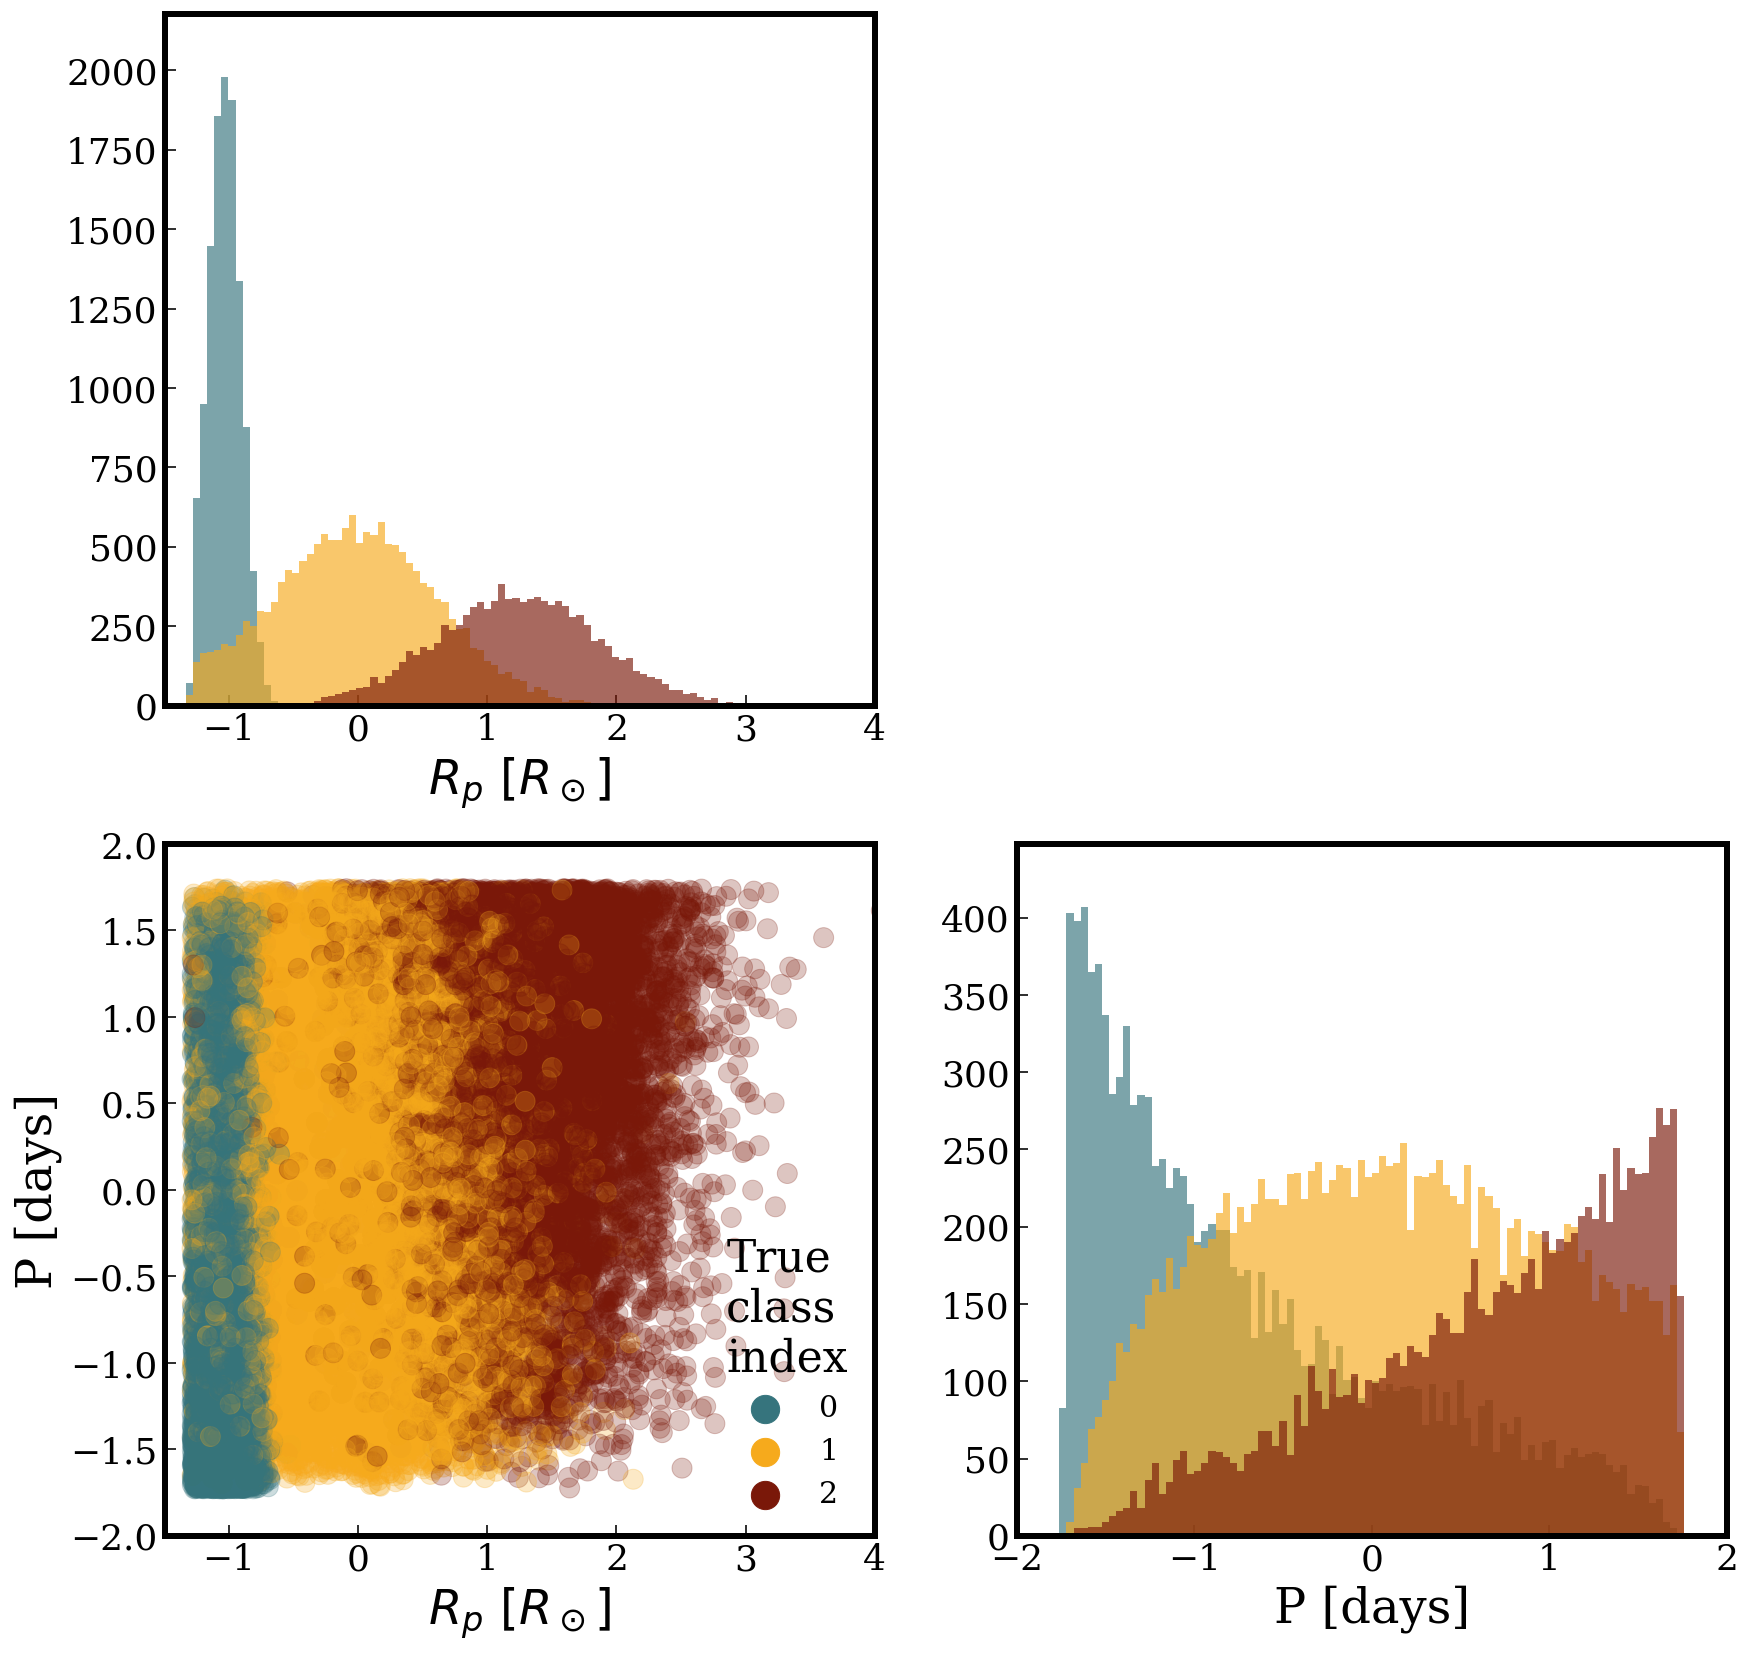

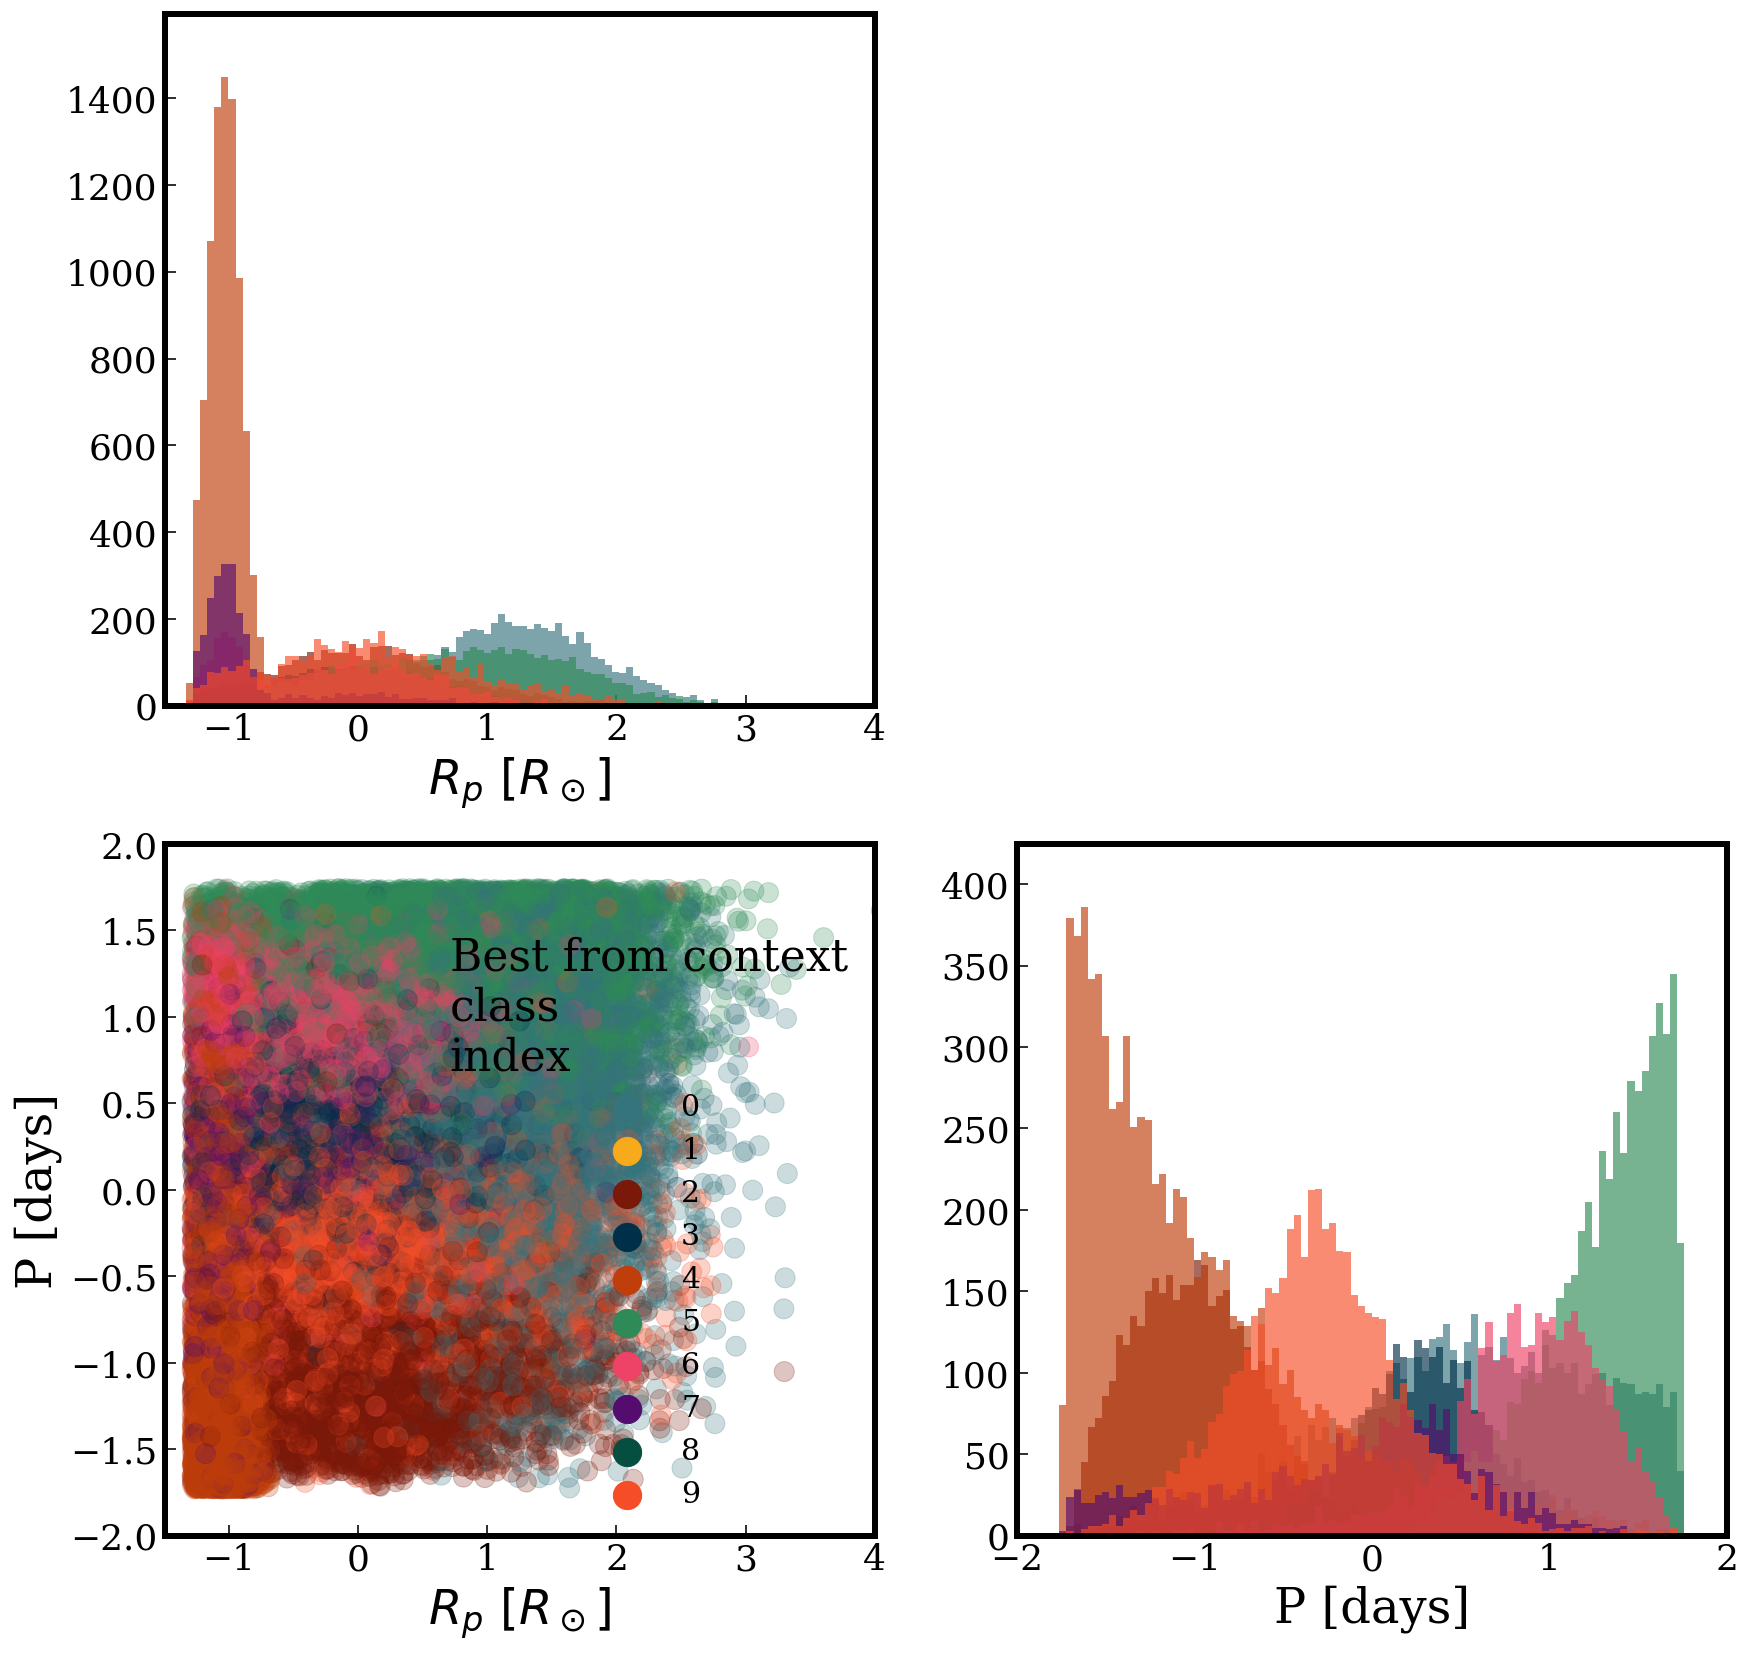

In [467]:
classColoursList = ['#36747D','#F6AA1C','#7A1809','#003049','#BF3E0B','#2E8B57','#EE4266','#540D6E','#064F40','#F54D27']
#cl = ['#7A1809','#36747D','#F6AA1C']

# TRUTHS and RESULTS
#arrays_ = [trueClass, bestClass]
#titles_ = ["True","Best"]
#plotTitles_ = ["truths","results"]

arrays_ = [trueClass, bestClass_fromContext]
titles_ = ["True","Best from context"]
plotTitles_ = ["truths","results_fromcontext"]

for h in range(0,2):
#for h in range(1,2):
    class_colourMaps,class_colours,class_legendColours,class_legendEntries = makePlotColours(arrays_[h],classColoursList)
    
    fig = plt.figure(figsize=(7*n_features,7*n_features))
    gs = gridspec.GridSpec(n_features, n_features)

    for i in range(n_features):
        for j in range(n_features):
            if i>j:
                ax = plt.subplot(gs[i,j])
                makePlot(ax,
                        xdata=data[:,j],#+arrays_[h]/3.,
                        ydata=data[:,i],
                        colours=class_colours,
                        xlim=scaledLimits[j],
                        ylim=scaledLimits[i],
                        legendTitle="{0}\nclass\nindex".format(titles_[h]),
                        legendEntries=np.array(class_legendEntries).astype(int),
                        legendColours=class_legendColours,
                        #xscale="log",
                        #yscale="log",
                        xlabel=labels[j],
                        ylabel=labels[i],
                        alpha=0.25)

            if i==j:
                ax = plt.subplot(gs[i,j])
                toHist = []
                nmax = 0
                for k in np.unique(arrays_[h]).astype(int):
                    #toHist.append(data[:,i][arrays_[h]==k])
                    try:
                        n,bins,patches=ax.hist(data[:,i][arrays_[h]==k],bins=100,color=class_legendColours[k],range=scaledLimits[i],alpha=0.65)
                        if np.max(n)>nmax:
                            nmax=np.max(n)
                    except IndexError:
                        n,bins,patches=ax.hist(data[:,i][arrays_[h]==(k)],bins=100,color=class_legendColours[(k-1)],range=scaledLimits[i],alpha=0.65)
                        if np.max(n)>nmax:
                            nmax=np.max(n)
                    
                #n,bins,patches = ax.hist(toHist,density=True,stacked=True,bins=100,color=class_legendColours,range=scaledLimits[i],alpha=1)
                #nmax = np.max(n)
                ax.set_xlabel(labels[i],fontsize=24)
                ax.tick_params(labelsize=18)
                ax.set_xlim(scaledLimits[i])
                ax.set_ylim(0,nmax*1.1)


    plt.subplots_adjust(wspace=0.2,hspace=0.2)
    #plt.show()
    plt.savefig("./simulatedPlanets/{0}/fake_grammaticalSystems_{1}_{2}.png".format(experimentClass,experimentName,plotTitles_[h]),fmt="png")

In [475]:
for i in range(1,14):
    print("1 mod {0} is {1}".format(i,1%i))
    print("11 mod {0} is {1}".format(i,11%i))
    print("12 mod {0} is {1}".format(i,12%i))
    print("13 mod {0} is {1}".format(i,13%i))
    print("")

1 mod 1 is 0
11 mod 1 is 0
12 mod 1 is 0
13 mod 1 is 0

1 mod 2 is 1
11 mod 2 is 1
12 mod 2 is 0
13 mod 2 is 1

1 mod 3 is 1
11 mod 3 is 2
12 mod 3 is 0
13 mod 3 is 1

1 mod 4 is 1
11 mod 4 is 3
12 mod 4 is 0
13 mod 4 is 1

1 mod 5 is 1
11 mod 5 is 1
12 mod 5 is 2
13 mod 5 is 3

1 mod 6 is 1
11 mod 6 is 5
12 mod 6 is 0
13 mod 6 is 1

1 mod 7 is 1
11 mod 7 is 4
12 mod 7 is 5
13 mod 7 is 6

1 mod 8 is 1
11 mod 8 is 3
12 mod 8 is 4
13 mod 8 is 5

1 mod 9 is 1
11 mod 9 is 2
12 mod 9 is 3
13 mod 9 is 4

1 mod 10 is 1
11 mod 10 is 1
12 mod 10 is 2
13 mod 10 is 3

1 mod 11 is 1
11 mod 11 is 0
12 mod 11 is 1
13 mod 11 is 2

1 mod 12 is 1
11 mod 12 is 11
12 mod 12 is 0
13 mod 12 is 1

1 mod 13 is 1
11 mod 13 is 11
12 mod 13 is 12
13 mod 13 is 0



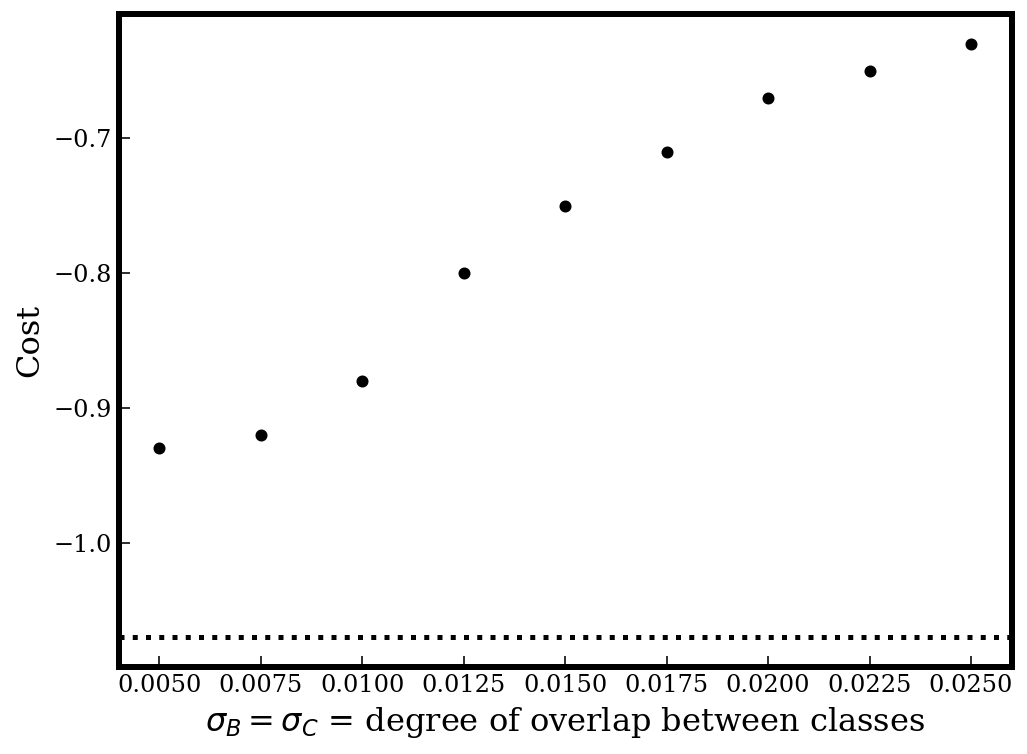

In [197]:
# Plot best-achieved cost vs. degree of overlap between classes B and C
overlaps = np.array((0.005, 0.0075, 0.01, 0.0125, 0.015, 0.0175, 0.02, 0.0225, 0.025))
costs = np.array((-0.93, -0.92, -0.88, -0.80, -0.75, -0.71, -0.67, -0.65, -0.63))
fig, ax= plt.subplots(1,1,figsize=(8,6))
ax.axhline(-1.07,color='k',ls=':')
ax.plot(overlaps, costs,'k.',ms=10)
ax.set_xlabel(r"$\sigma_B = \sigma_C$ = degree of overlap between classes",fontsize=16)
ax.set_ylabel("Cost",fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=12)
#plt.show()
plt.savefig("./cost_vs_classoverlap.pdf",fmt="pdf")

# What are the weights in layer 1 doing?

In [12]:
from matplotlib import cm

In [13]:
# Context rep
ws = np.load("./ContextRep_linear1weights.npy")
bs = np.load("./ContextRep_linear1biases.npy")
nSteps = np.shape(ws)[0]
nInputs = np.shape(bs)[1]
print(np.shape(ws))
print(np.shape(bs))

(4, 160)
(4, 20)


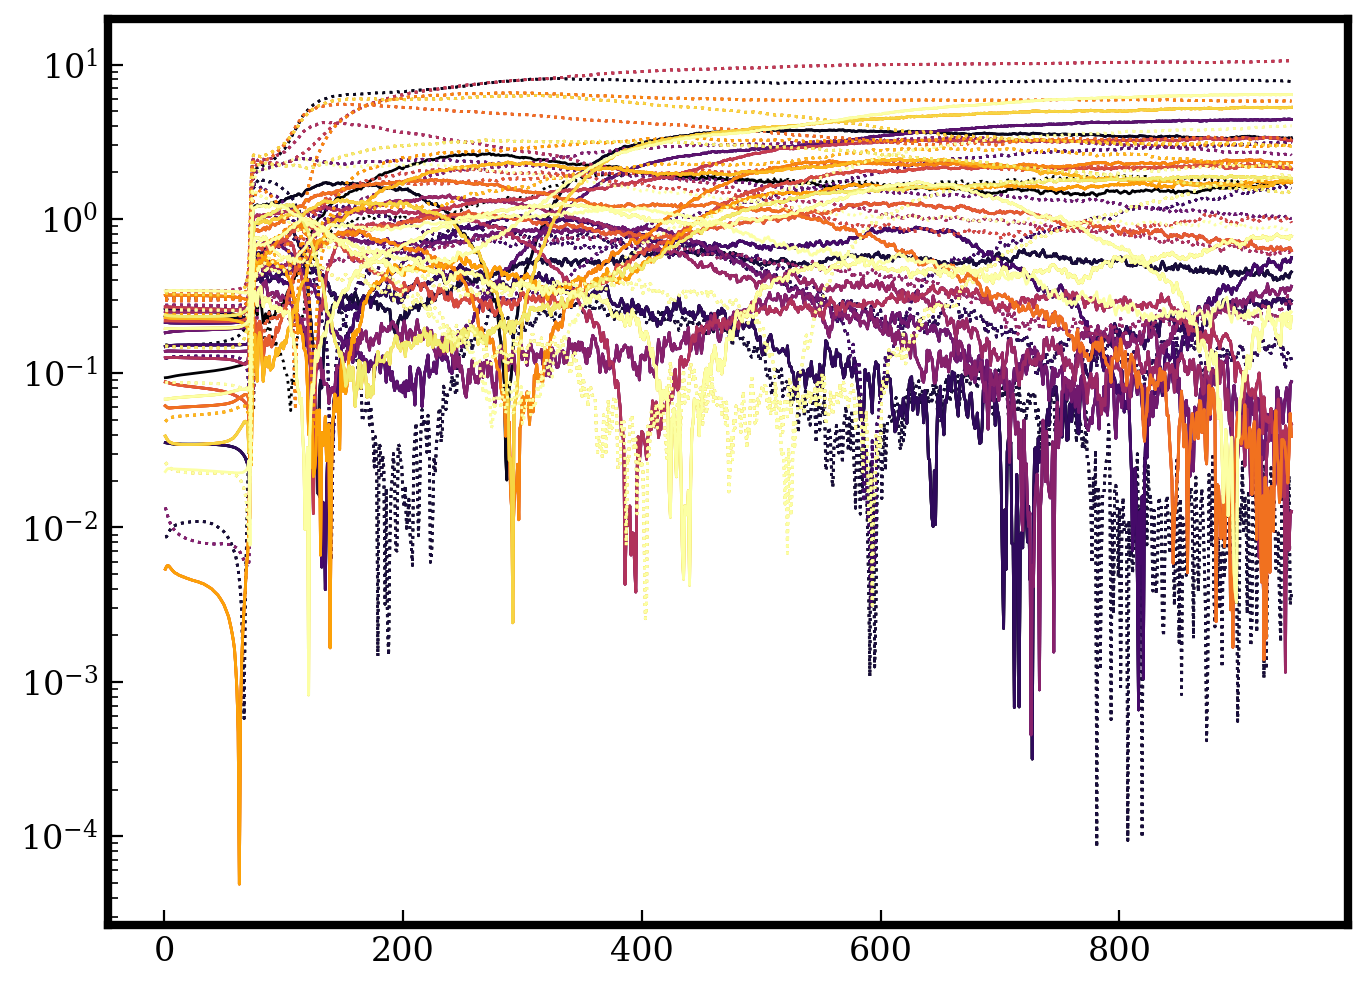

In [133]:
colors = [ cm.inferno(x) for x in np.linspace(0, 1, nInputs) ]

fig = plt.figure(figsize = (8,6))
for i in range(0,nInputs):
    for j in np.arange(0,8,2):
        plt.plot(np.arange(nSteps),np.abs(ws[:,2*i + j]),color = colors[i],ls='-',lw=1) # feature 0 weights
    
    for j in np.arange(1,9,2):
        plt.plot(np.arange(nSteps),np.abs(ws[:,2*i + j]),color = colors[i],ls=':',lw=1) # feature 1 weights
    
    #plt.plot(np.arange(nSteps),np.abs(bs[:,i]),color = colors[i],ls='--',lw=1)         # biases

plt.yscale("log")
#plt.show()
plt.savefig("./simulatedPlanets/{0}/fake_grammaticalSystems_{1}_ContextRep_linear1.pdf".format(experimentClass,experimentName),fmt="pdf")

In [134]:
# Planet rep
ws = np.load("./PlanetRep_linear1weights.npy")
bs = np.load("./PlanetRep_linear1biases.npy")
nSteps = np.shape(ws)[0]
nInputs = np.shape(bs)[1]
print(np.shape(ws))
print(np.shape(bs))

print(nSteps)
print(nInputs)

(945, 40)
(945, 20)
945
20


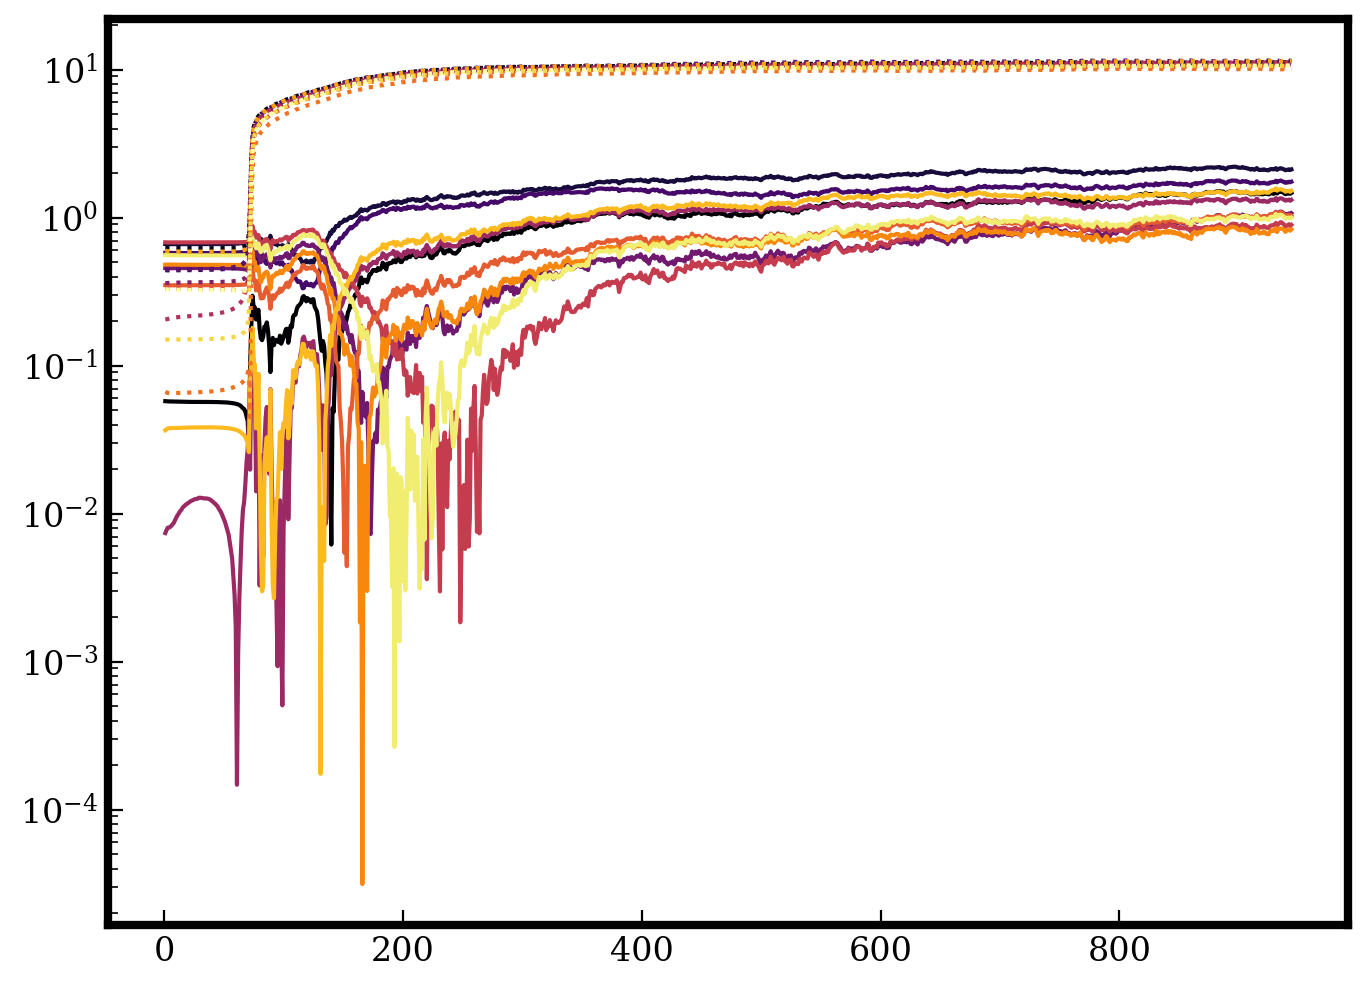

In [135]:
colors = [ cm.inferno(x) for x in np.linspace(0, 1, nInputs) ]

fig = plt.figure(figsize = (8,6))
for i in np.arange(0,nInputs,2):
    plt.plot(np.arange(nSteps),np.abs(ws[:,i]),color = colors[i],ls='-',lw=1.5)     # feature 0 weights
    
for i in np.arange(1,nInputs+1,2):
    plt.plot(np.arange(nSteps),np.abs(ws[:,i]),color = colors[i],ls=':',lw=1.5) # feature 1 weights

#for i in range(0,nInputs):
    #plt.plot(np.arange(nSteps),np.abs(bs[:,i]),color = colors[i],ls='--',lw=1)       # biases
#plt.title("linear 1 weights. - = Rp weight; : = P weight; -- = bias")
plt.yscale("log")
#plt.show()
plt.savefig("./simulatedPlanets/{0}/fake_grammaticalSystems_{1}_PlanetRep_linear1.pdf".format(experimentClass,experimentName),fmt="pdf")

# Look at POS tagging results

In [ ]:
posResults = np.load("../POStagger/example.w_classprobs.npy")
print(posResults)
print(np.argmax(posResults,axis=1))
words = ['chased','chased','chased','cat','the','dog','dog','rat','the','the','cat','the','the','the','rat'] # as encoded in Y1
posTruths = ['V', 'V', 'V', 'N', 'D', 'N', 'N', 'N', 'D', 'D', 'N', 'D', 'D', 'D', 'N']
posTruthIdxs = np.array((0, 0, 0, 1, 2, 1, 1, 1, 2, 2, 1, 2, 2, 2, 1))
print(posTruthIdxs)

# So everything appears to be working fine, except that the ordering in Y1 is not intuitive, and I should double-check
# that it's right in the planet case.

## What about when I make sentences like: "dog dog dog dog", "chased chased chased", "the the the the the the". Does it work?

In [ ]:
# Yes!! Although something about indexing is a little weird...
posSameResults = np.load("../POStagger/exampleSame.w_classprobs.npy")
posSameIdxs = np.load("../POStagger/exampleSame.w_idxs.npy")
posSameIdxs[posSameIdxs==3] = 0
posSameIdxs[posSameIdxs==2] = 4
posSameIdxs[posSameIdxs==1] = 2
posSameIdxs[posSameIdxs==4] = 1

print(posSameIdxs)
print(np.argmax(posSameResults,axis=1))

In [ ]:
test = np.zeros((1000,3))
print(np.shape(np.mean(test,axis=0)))

In [ ]:
test = np.vstack((np.ones(10),np.zeros(10)))

In [ ]:
print(test.T)
print(np.ravel(test.T))